In [92]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

from bs4 import BeautifulSoup
import urllib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm,tqdm_notebook
import os

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D,Lambda, ZeroPadding2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.regularizers import l1_l2

import gc


class MyException(Exception):
    pass

Populating the interactive namespace from numpy and matplotlib


C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
HOWMANY = 1107
MAXLINKS = 1109
DEBUG = True
TMP_DIR = 'D:\\tmp'
FORCE_RELOAD = False#True
LOAD = True
PREPROCESS = True#False
batch_size = 128   # ile obrazków przetwarzamy na raz (aktualizacja wag sieci następuje raz na całą grupę obrazków)
epochs = 12         # ile epok będziemy uczyli
SIZE = (750,750)
SIDE = 75
IMPOSITION = 5
HOWMANYPERIMAGE = int(SIZE[0]*SIZE[1]/SIDE/SIDE)
IMAGESPERFILE = 100
assert int(SIZE[0]*SIZE[1]/SIDE/SIDE)==HOWMANYPERIMAGE

In [3]:
def loadImage(url):
    raw = urllib.request.urlopen(url).read()
    npraw= np.array(bytearray(raw),dtype=np.uint8)
    return cv2.imdecode(npraw,-1)#-1 -> as is (with the alpha channel)

def getImageName(url):
    return url.split('/').pop().split('.').pop(0)

def pickleBigDataset(prefix,dataset,size):
    j = int(np.ceil(len(dataset)/size))
    for i in range(1,j+1):
        np.save(os.path.join(TMP_DIR, prefix+str(i)),np.array(dataset[size*(i-1):size*i]))

def unpickleBigDataset(prefix):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f))
                 and f.startswith(prefix)]
    dataset = []
    if len(onlyfiles)>0:
        print("Loading...")
        dataset = np.load(os.path.join(TMP_DIR, onlyfiles[0]))
        print("Loaded first")
        for f in tqdm_notebook(onlyfiles[1:]):
            dataset=np.append(dataset,np.load(os.path.join(TMP_DIR, f)),axis=0)
    return dataset
#     return np.load(os.path.join(TMP_DIR, "{}.npy".format(prefix)))
    
            
def loadImagesFromSite(url,prefix):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f)) and f.startswith(prefix)]
    if len(onlyfiles)==0 or FORCE_RELOAD:
        imgs = []
        I = None
        
    else:
        imgs = [img for img in unpickleBigDataset(prefix)[:HOWMANY]]
        I = len(imgs)
    print("Cached images {}.".format(I if I is not None else 0))
    
    if (HOWMANY is not None and len(imgs)<HOWMANY and len(imgs)<MAXLINKS) or (len(imgs)<MAXLINKS and HOWMANY is None):
        print("Loading images from {}".format(url))
        print("Proceeding from {} image.".format(I if I is not None else 0))

        s = IMAGESPERFILE

        with urllib.request.urlopen(url) as response:
            html = BeautifulSoup(response.read(),"lxml")
            i = I if I is not None else 0
            links = html.find_all('a')[I:HOWMANY]
            for link in tqdm_notebook(links):
                img = loadImage(link.get('href'))  
                img = cv2.resize(img,SIZE)
#                 print(link.get('href'))
                imgs += [cv2.resize(img,SIZE)]
                if i%s==0:
                    pickleBigDataset(prefix,imgs,s)
                i+=1
        pickleBigDataset(prefix,imgs,s)
    
        
    return np.array(imgs)  

def saveDataset(X,Y,prefix=""):
    with open('pickledDatasetX'+prefix,'wb') as f:
        pickle.dump(X,f)
    with open('pickledDatasetY'+prefix,'wb') as f:
        pickle.dump(Y,f)
        
def loadDataset(prefix=""):
    try:
        X = unpickleBigDataset('x')
        Y = unpickleBigDataset('y')
        if len(X) == len(Y) and len(X) == HOWMANY:
            return X,Y
        else:
            print("Failed loading dataset from file system")
            return None,None
    except:
        print("Failed loading dataset from file system")
        return None,None
    
def display(X,Y,howmany=None):
    if howmany is None:
        howmany = X.shape[0]
        
    for i in range(howmany):
        print(X[i].max(),X[i].min())
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(X[i])
        plt.subplot(1,2,2)
        plt.imshow(Y[i])
        

In [140]:
# def get_patches(image,size,side,imposition):
#     patches = []
    
    
#     for i in range(int(size[0]/side)):
#         for j in range(int(size[1]/side)):
#             patches += [image[i*side:(i+1)*side,j*side:(j+1)*side]]
#     return patches

def get_patches(image,size,side,imposition):
    patches = []
    
    if len(image.shape)==3:
        img = np.zeros((image.shape[0]+imposition,image.shape[1]+imposition,3))
        for i in range(3):
            img[...,i] = np.pad(image[...,i],((imposition,0),(imposition,0)),'reflect')
        image = img
    else:
        image = np.pad(image,((imposition,0),(imposition,0)),'reflect')
        
    print(image.shape)

    for i in range(int(size[0]/side)):
        for j in range(int(size[1]/side)):
            imp1=np.max([i*side-imposition,0])
            imp2=(i+1)*side+imposition if imp1!=0 else (i+1)*side+imposition*2
            imp3=np.max([j*side-imposition,0])
            imp4=(j+1)*side+imposition if imp3!=0 else (j+1)*side+imposition*2
            patches += [image[imp1:imp2,imp3:imp4]]
    return patches

def preprocessorX(image):
    size,side,imposition = SIZE,SIDE,IMPOSITION
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[...,0]

    image = image.astype(np.uint8)
    image = cv2.fastNlMeansDenoising(image,None,9,13)
    #korekcja gamma
    image = image**0.9
    
    patches = get_patches(image,size,side,imposition)

    for j in range(len(patches)):        
        patches[j] = patches[j].astype(np.float32)
                
        patches[j] -= patches[j].mean()
        patches[j] /= patches[j].std()

        #remove outliers
        patches[j][patches[j]<-3] = -3
        patches[j][patches[j]>3] = 3
        
        #between -1,1
        for i in range(3):
            dzielnik = np.max(np.abs([patches[j].min(),patches[j].max()]))
            if dzielnik != 0:
                patches[j] /= dzielnik       
        cv2.morphologyEx(patches[j],cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)))
        cv2.morphologyEx(patches[j],cv2.MORPH_CLOSE,cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)))
        
    return patches
    
def preprocessorY(image):
    size,side,imposition = SIZE,SIDE,IMPOSITION

    image = image.astype(np.float32)
    # if image.max() > 1:
        # image /= 255
    # for i in range(3):
        # image[...,i] = (image[...,i] - image[...,i].min())/(image[...,i].max() - image[...,i].min())
    image[image!=0] = 1# = (image - image.min())/(image.max() - image.min())
    image[image==0] = 0#CLASS_ZERO
    return get_patches(image,size,side,imposition)
    
def getRoadStats(arr,mask):
    b = mask.astype(np.bool)
    x = arr[b]
    if len(x) != 0:
        return [x.max(0),x.min(0),x.mean(0),x.std(0),np.median(x,axis=0)]
    else:
        return None

def preprocessXY(X,Y):
    
    r = []
    for i in range(len(X)):
        s = getRoadStats(X[i],Y[i])
        if s is not None:
            r += [s]
            
    return np.array(r).mean(0)
    

def preprocess(images,preprocessor,prefix):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f)) and f.startswith(prefix)]
    if len(onlyfiles)==0:
        I = None
        result = []
    else:
        result = unpickleBigDataset(prefix)[:HOWMANY*HOWMANYPERIMAGE]
        I = int(len(result)/HOWMANYPERIMAGE)
    print("Cached images {}.".format(len(result)))
    
    s = int(IMAGESPERFILE*HOWMANYPERIMAGE / 4 )
    if len(result)<HOWMANY*HOWMANYPERIMAGE:
        print("Preprocessing images.")
        print("Proceeding from {} image.".format(I if I is not None else 0))
        i = I if I is not None else 0
        ignoring = []
        for image in tqdm_notebook(images[I:]):
            r = preprocessor(image)
            result += r
#             i += HOWMANYPERIMAGE
#             if i%s==0:
#                 pickleBigDataset(prefix,result,s)
        images = None
        gc.collect()
        pickleBigDataset(prefix,result,s)
    images = None
        
    return np.array(result)

In [5]:
def doSomeDeepLearning(X=None,Y=None,side=85):
    num_classes = 2    # ile klas będziemy rozpoznawali

    # input image dimensions
    img_rows, img_cols = side,side   # takie wymiary mają obrazki w bazie MNIST

    # the data, shuffled and split between train and test sets
    try:
        x_train = unpickleBigDataset('xain')
        y_train = unpickleBigDataset('yain')
        x_test = unpickleBigDataset('xest')
        y_test = unpickleBigDataset('yest')
        if len(x_train)==0 or len(y_train)==0 or len(x_test)==0 or len(y_test)==0:
            raise Exception
        if len(x_train) + len(x_test)!=HOWMANY:
            raise MyException
    except:
        if X is None or Y is None:
            raise MyException
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
            y_train = y_train.reshape(y_train.shape[0], 1, img_rows, img_cols)
            y_test = y_test.reshape(y_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
            y_train = y_train.reshape(y_train.shape[0], img_rows, img_cols, 1)
            y_test = y_test.reshape(y_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
        s = IMAGESPERFILE * HOWMANYPERIMAGE
        pickleBigDataset('xain',x_train,s)
        pickleBigDataset('yain',y_train,s)
        pickleBigDataset('xest',x_test,s)
        pickleBigDataset('yest',y_test,s)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    curr_epoch = -1
    onlyfiles = [f for f in os.listdir('.') if os.path.isfile(os.path.join('.', f)) and f.startswith('moj_ulubiony_model') and f.endswith('.h5')]
    if len(onlyfiles) == 0:
        print("No saved model. Preparing model.")
        imput = Input(shape=(side,side,3))
        conv1 = Conv2D(32, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(imput)
        conv1 = Conv2D(32,
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv1)
        conv1 = Conv2D(32, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv1)
        dropout1 = Dropout(0.2)(conv1)
        maxpool1 = MaxPooling2D(pool_size=(2, 2))(dropout1)
        conv2 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(maxpool1)
        conv2 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv2)
        conv2 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv2)
        dropout2 = Dropout(0.25)(conv2)
        maxpool2 = MaxPooling2D(pool_size=(2, 2))(dropout2)
        conv3 = Conv2D(128, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(maxpool2)
        conv3 = Conv2D(128, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv3)
        conv3 = Conv2D(128, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv3)
        dropout3 = Dropout(0.25)(conv3)
        upsample1 = UpSampling2D(size=(2,2))(dropout3)
        
        concat1 = concatenate([upsample1,conv2,])#lambda1])
        conv4 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(concat1)
        conv4 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv4)
        conv4 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv4)
        dropout4 = Dropout(0.25)(conv4)
        upsample2 = UpSampling2D(size=(2,2))(dropout4)
        zpad1 = ZeroPadding2D(((1,0),(1,0)))(upsample2)
        concat2 = concatenate([zpad1,conv1])
        conv5 = Conv2D(32, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(concat2)
        conv5 = Conv2D(32, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv5)
        conv5 = Conv2D(1, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv5)
        model = Model(inputs=imput, outputs=conv5)

        model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(),       
                  metrics=['accuracy']) 
    elif len(onlyfiles) == 1:
        print("Saved model:\"{}\"".format(onlyfiles[0]))
        model = keras.models.load_model(onlyfiles[0])
    else:
        onlyfiles = map(lambda y:filter(lambda x:x is not None and x.startswith('epoch'),y.split('.')[0].split('_')),onlyfiles)
        curr_epoch = max(list(map(lambda x:int(x[4:]),onlyfiles)))
        model = keras.models.load_model("moj_ulubiony_model_epoch{}.h5".format(curr_epoch))
        print("Saved model:\"moj_ulubiony_model_epoch{}.h5\"".format(curr_epoch))
    curr_epoch += 1
    print("Current epoch:{}".format(curr_epoch))
    model.summary()
    
    
    for i in range(curr_epoch,epochs):
        model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=1,
                      verbose=1,
                      validation_data=(x_test, y_test))
        model.save("moj_ulubiony_model_epoch{}.h5".format(i))
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [128]:
if __name__=="__main__":
    try:
        doSomeDeepLearning()
    except MyException as e:
        urlX = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html"
        urlY = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/index.html"

        if LOAD:
            print("Loading images (X)")
            X = loadImagesFromSite(urlX,'f')
        if PREPROCESS:
            print("Preprocessing images (X)")
            X = preprocess(X,preprocessorX,'x')
        if LOAD:
            print("Loading images (Y)")
            Y = loadImagesFromSite(urlY,'z')
        if PREPROCESS:
            print("Preprocessing images (Y)")
            Y = preprocess(Y,preprocessorY,'y')

            r = preprocessXY(X,Y)
            print("\n\t| {}\t\t\t| {}\t\t| {}".format('Hue', 'Saturation', 'Value'))
            l = ['max','min','avg','std','median']
            for i,(c1, c2, c3) in enumerate(r):  
                print("{}\t| {}\t| {}\t| {}".format(l[i],c1, c2, c3))

        doSomeDeepLearning(X,Y)

Loading...
Loaded first


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Loading...
Loaded first


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Loading...
Loaded first


HBox(children=(IntProgress(value=0, max=2), HTML(value='')))


Loading...
Loaded first


HBox(children=(IntProgress(value=0, max=2), HTML(value='')))


Loading images (X)
Loading...
Loaded first


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Cached images 1100.
Loading images from https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html
Proceeding from 1100 image.


HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-5-c92b1310276c>", line 16, in doSomeDeepLearning
    raise MyException
MyException

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-128-1bc827312ebd>", line 3, in <module>
    doSomeDeepLearning()
  File "<ipython-input-5-c92b1310276c>", line 19, in doSomeDeepLearning
    raise MyException
MyException

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-128-1bc827312ebd>", line 10, in <module>
    X = loadImagesFromSite(urlX,'f')
  File "<ipython-input-3-d4dabaad5727>", line 50, in loadImagesFromSite
    img = loadImage(link.get('href'))
  File "<ipython-input-3-d4dabaad5

KeyboardInterrupt: 

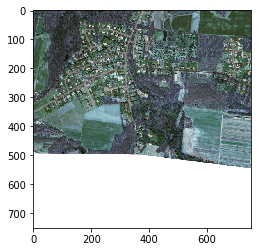

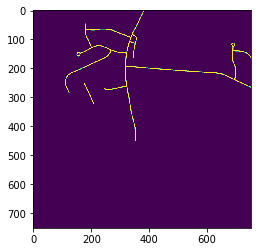

In [83]:
img = loadImage("http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078660_15.tiff")
img = cv2.resize(img,SIZE)
plt.imshow(img)
plt.show()
label = loadImage("http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/10078660_15.tif")
label = cv2.resize(label,SIZE)
plt.imshow(label)
plt.show()

(755, 755)


C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less
C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\jurgad\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


(755, 755)
28


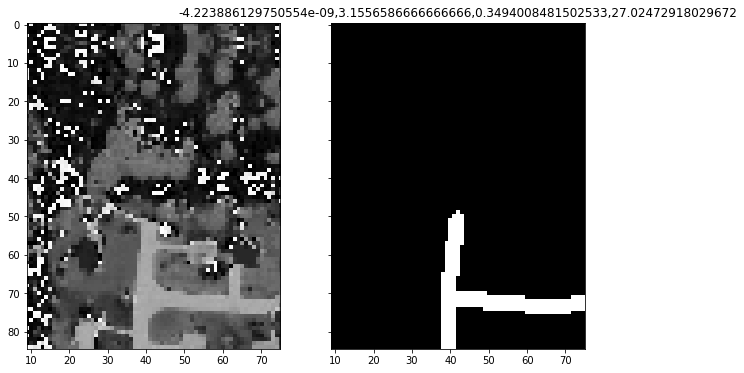

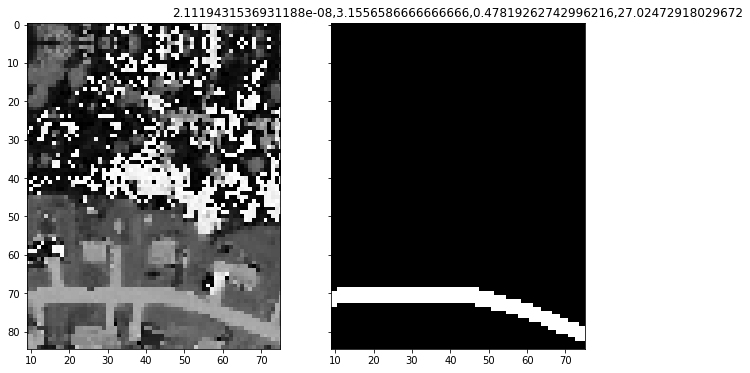

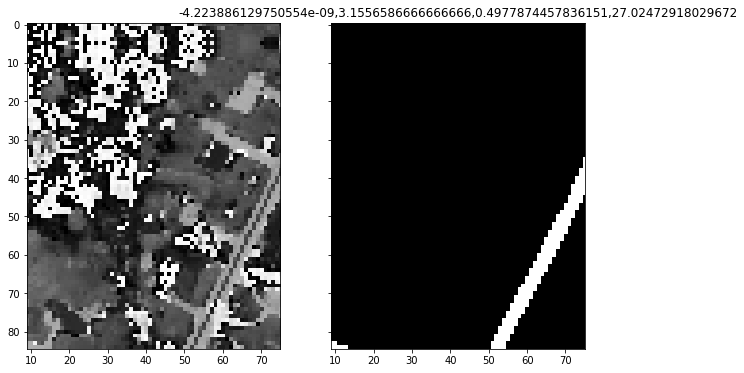

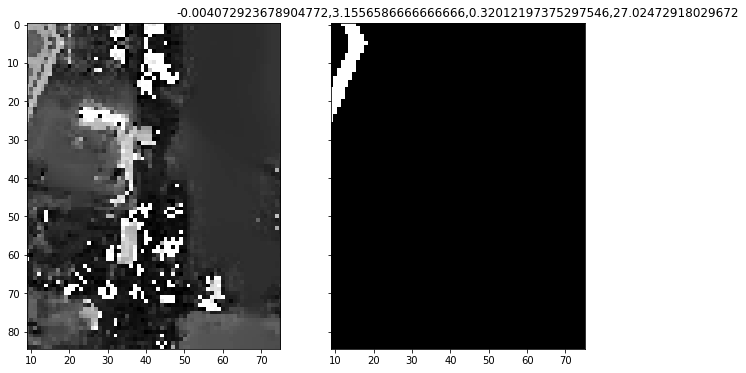

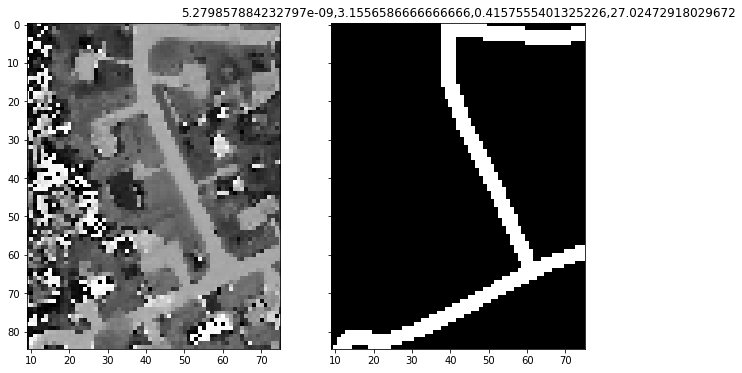

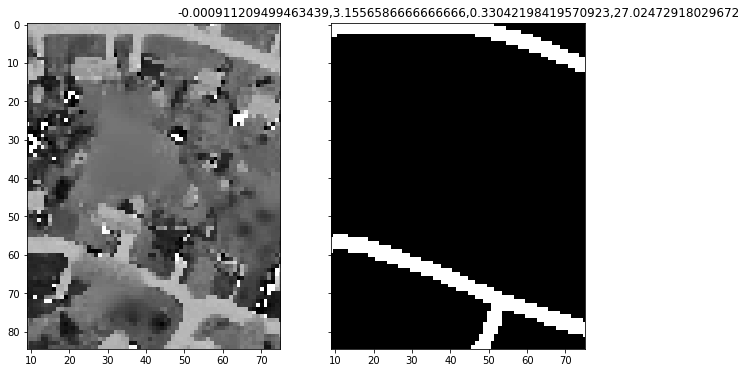

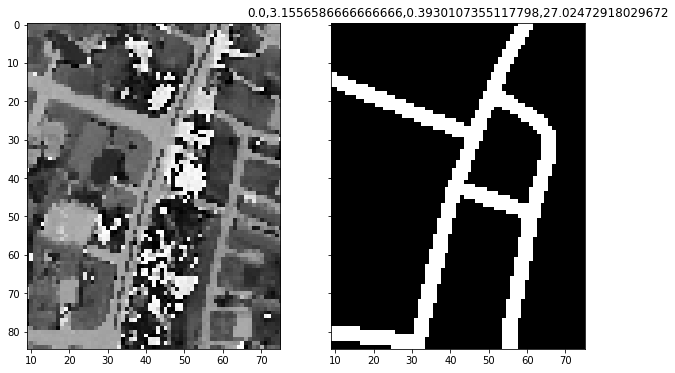

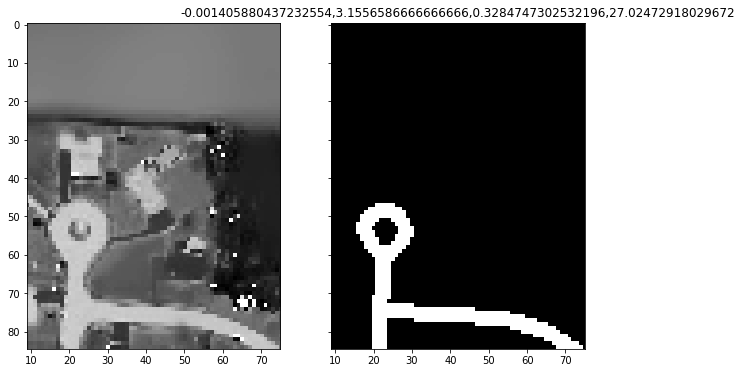

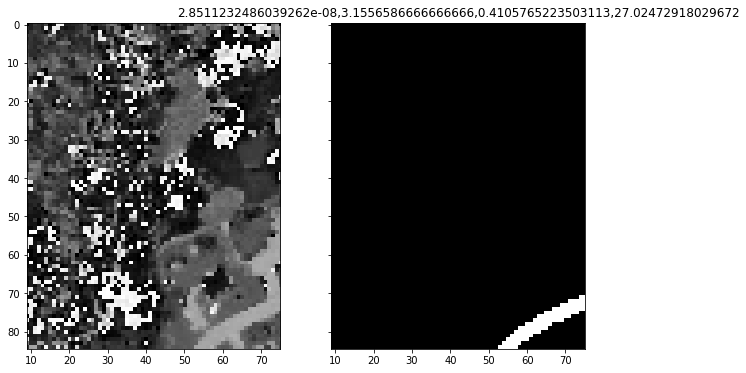

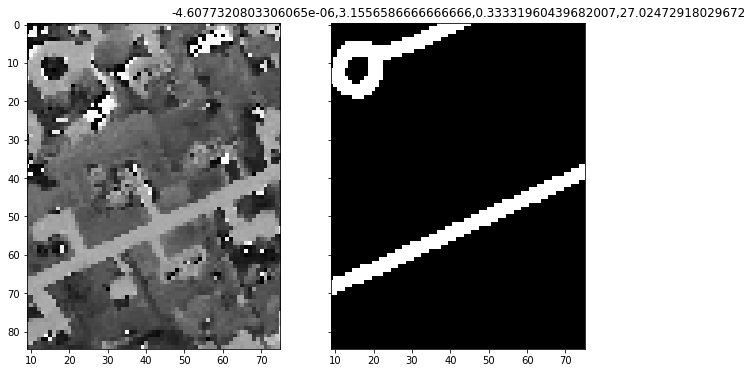

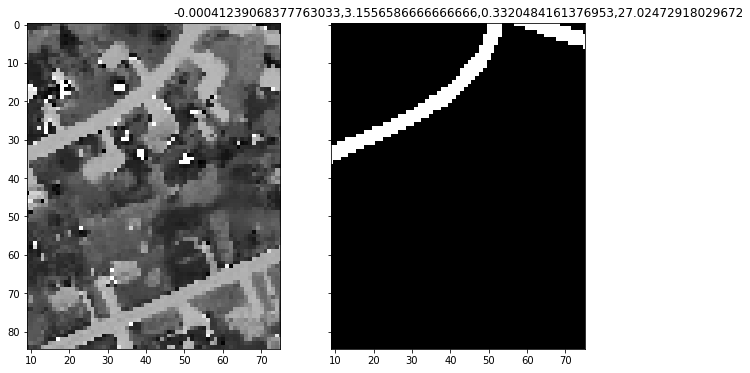

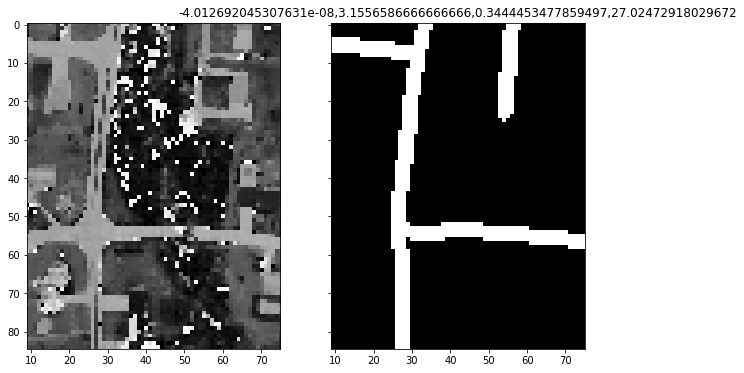

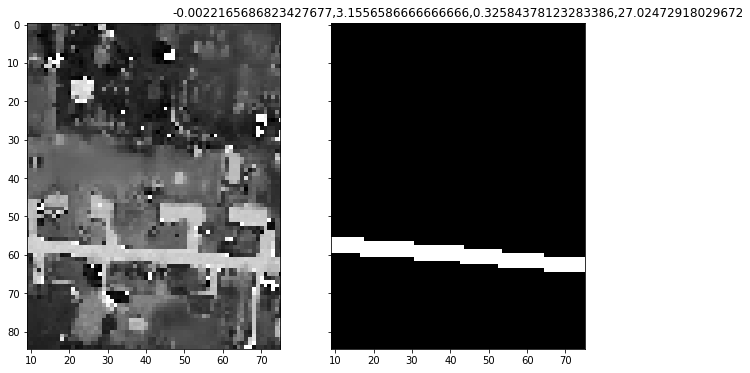

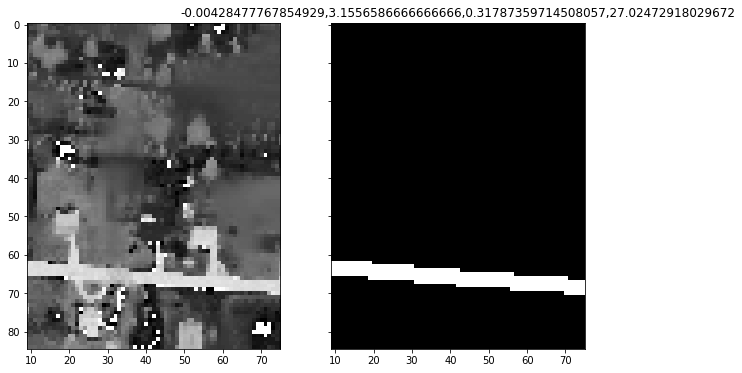

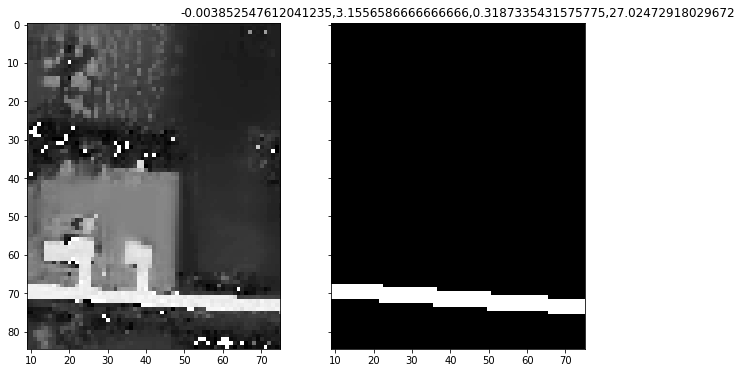

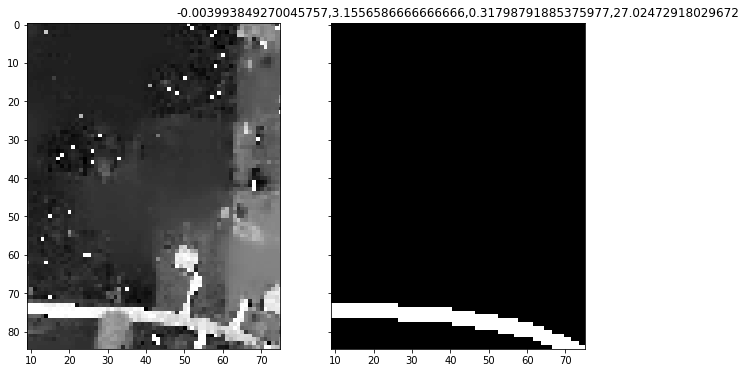

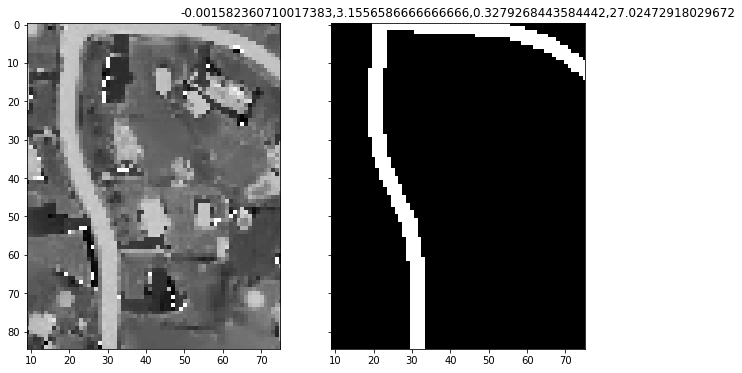

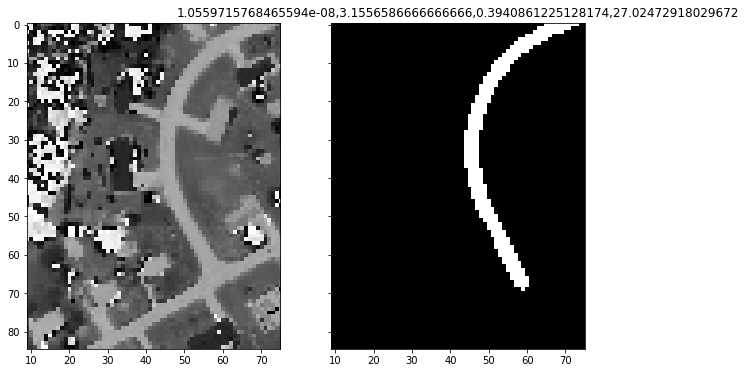

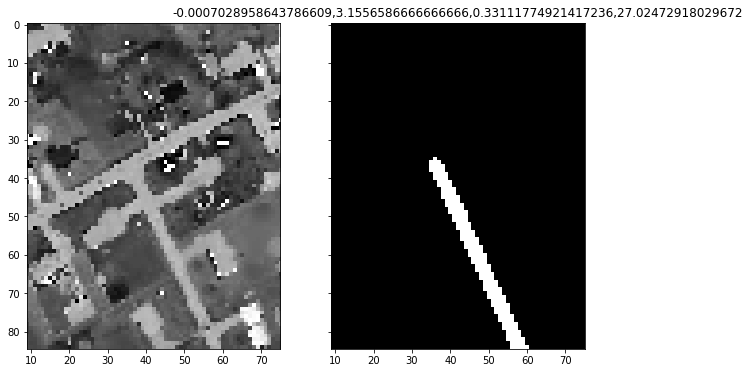

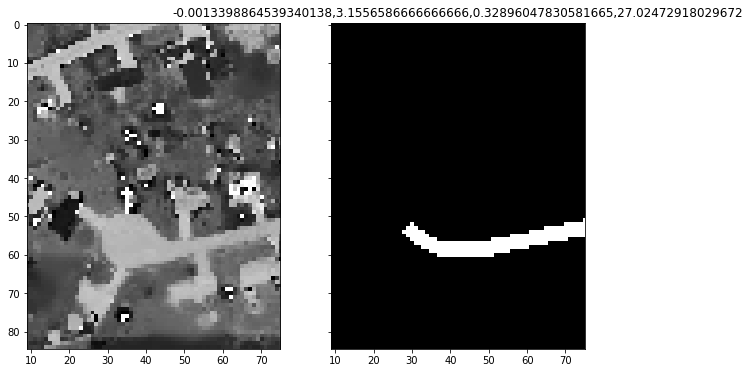

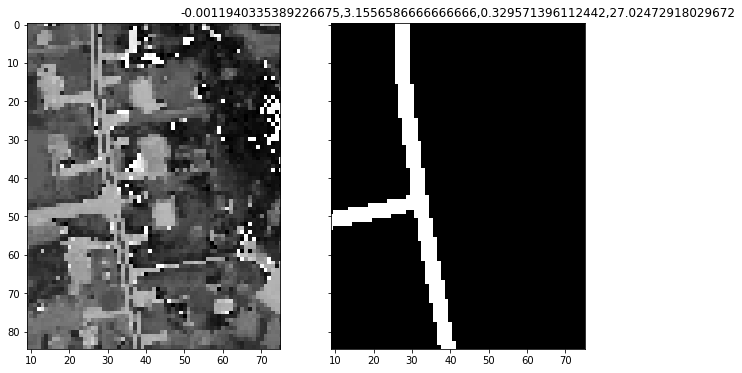

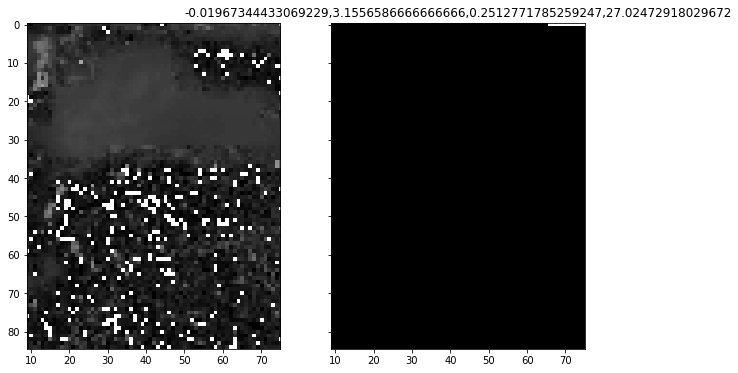

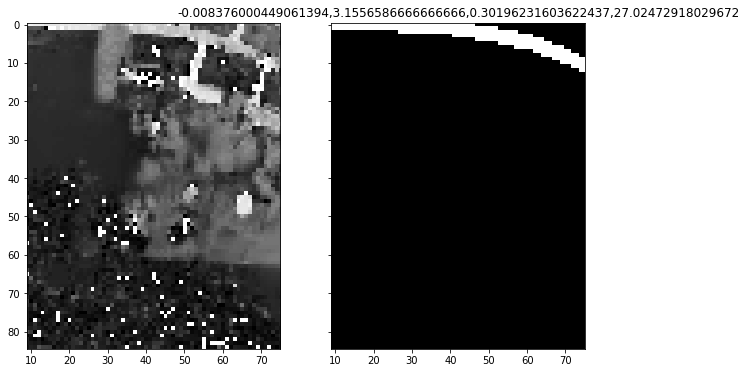

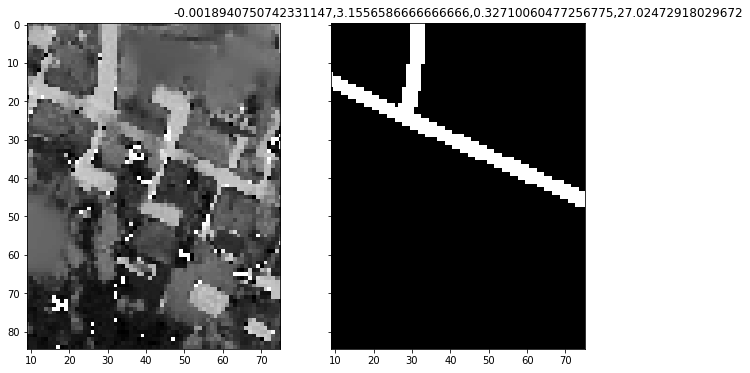

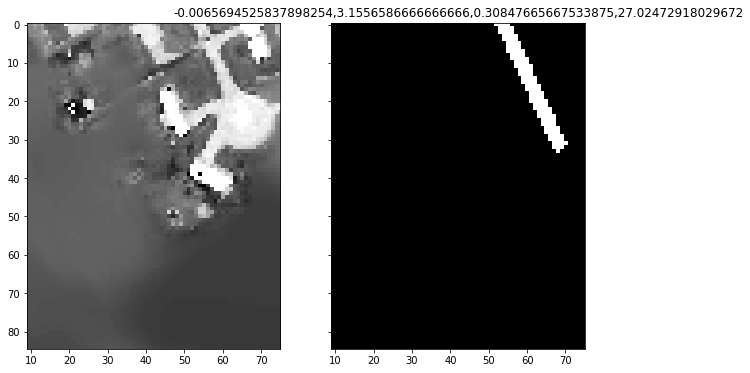

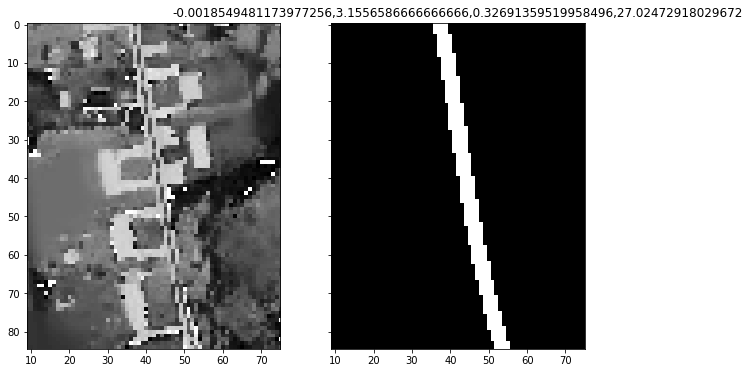

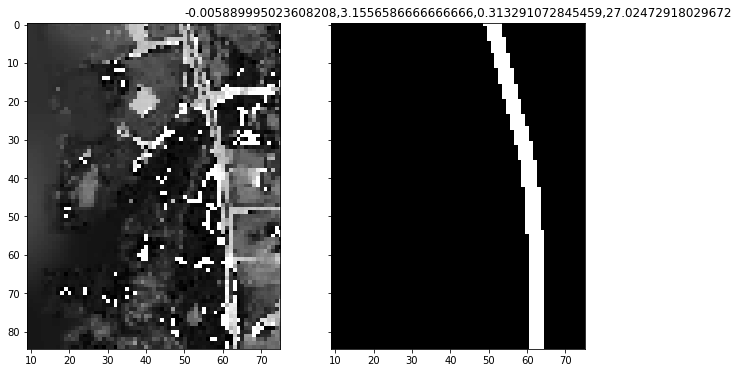

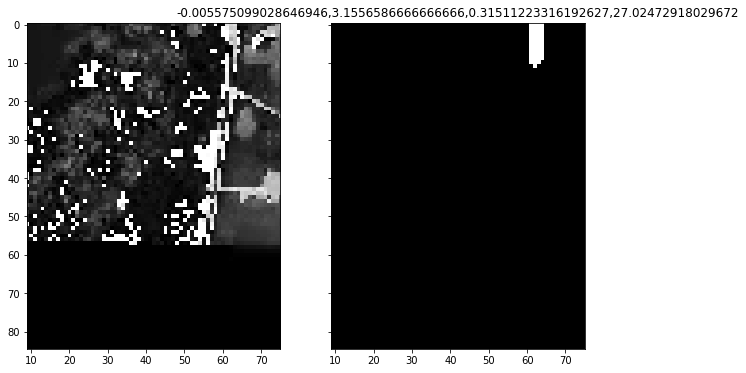

In [141]:
def normIt(img):
    if img.max()!=img.min():
        return (img - img.min())/(img.max() - img.min())
    else:
        return (img - img.min())
patches = np.array(preprocessorX(img))
labels = np.array(preprocessorY(label))
mask = [not (np.all(xyz==0) or np.all(xyz==1)) for xyz in labels]
patches = patches[mask]
labels = labels[mask]
mask = [not (np.all(xyz==0) or np.all(xyz==1)) for xyz in patches]
patches = patches[mask]
labels = labels[mask]
print(len(patches))
for i,patch in enumerate(patches):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plt.title("{},{},{},{}".format(patch.mean(),label.mean(),patch.std(),label.std()))
    ax1.imshow(normIt(patch),cmap='gray')
    ax2.imshow(normIt(labels[i]),cmap='gray')
#     plt.colorbar()
    plt.show()